# STAT0032 Group 12 Code

In [19]:
# General
import numpy as np
import pandas as pd

# Stats
from scipy.stats import norm
import statsmodels.api as sm

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

In [20]:
# Matplotlib font adjustments
import matplotlib as mpl
import matplotlib.font_manager as font_manager

plt.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

## Importing data

In [21]:
# Import data
hour_data = pd.read_csv("data/hour.csv")
day_data = pd.read_csv("data/day.csv")

## Checks that '*day.csv*' can be constructed from  '*hour.csv*'

In [22]:
# Collapse hour data at the day level
hour_data_collapsed = hour_data.groupby(['dteday'])[['temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']].agg(['mean', 'sum']).reset_index()

# Clean index names
hour_data_collapsed.columns = hour_data_collapsed.columns.to_flat_index()
for i in range(1, len(hour_data_collapsed.columns)):
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i]:hour_data_collapsed.columns[i][0] + '_' + hour_data_collapsed.columns[i][1]}, axis=1)
hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[0] : 'dteday'}, axis=1)

# Keep only variables of interest and rename
hour_data_collapsed = hour_data_collapsed.drop(['temp_sum', 'atemp_sum', 'windspeed_sum', 'casual_mean', 'registered_mean', 'cnt_mean'], axis=1)

for i in range(1, len(hour_data_collapsed.columns)):
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i].removesuffix('_mean')}, axis=1)
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i].removesuffix('_sum')}, axis=1)
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i] + '_collapsed'}, axis=1)

# Merge collapsed hour data with day data
merged_data = pd.merge(day_data, hour_data_collapsed, on='dteday')
columns_to_check = ['temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']
for c in columns_to_check:
    col = c + '_check'
    merged_data[col] = merged_data[c] - merged_data[c + '_collapsed']

# Assert checked versions are zero
for c in columns_to_check:
    col = c + '_check'
    assert merged_data[col].min() > -0.00001
    assert merged_data[col].max() < 0.00001

## Pre-processing

In [23]:
# Spring and summer only
peak_evenings = hour_data.copy()
peak_evenings = peak_evenings[peak_evenings.season.isin([2, 3])]

# Defining evening peak times
peak_evenings = peak_evenings[peak_evenings.workingday==1]
peak_evenings = peak_evenings[peak_evenings.hr.isin([15,16,17,18])]

## Histograms

In [24]:
# Collapse at the daily level
peak_evenings_daily = peak_evenings.copy()
peak_evenings_daily = peak_evenings_daily.groupby(['dteday', 'season'])[['cnt']].agg(['sum'])
peak_evenings_daily.columns=peak_evenings_daily.columns.droplevel(0)
peak_evenings_daily.reset_index(inplace=True)

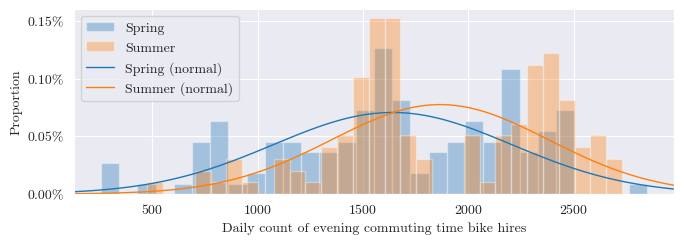

In [25]:
# Setup normal distributions
mu_spring, std_spring = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==2])
mu_summer, std_summer = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==3])

# Histogram plot
fig, ax = plt.subplots(figsize=(7.75,0.8*3))
ax.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==2], alpha=0.35, density=True, bins=30, label='Spring')
ax.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==3], alpha=0.35, density=True, bins=30, label='Summer')

# Plot the normal distributions
x_min, x_max = plt.xlim()
x = np.linspace(x_min, x_max, 100)
p_spring = norm.pdf(x, mu_spring, std_spring)
p_summer = norm.pdf(x, mu_summer, std_summer)
plt.plot(x, p_spring, 'C0', linewidth=1, label='Spring (normal)')
plt.plot(x, p_summer, 'C1', linewidth=1, label = 'Summer (normal)')

# Plotting setup
plt.margins(x=0)
ax.legend(loc = 'best')
ax.set_ylabel('Proportion')
ax.set_xlabel('Daily count of evening commuting time bike hires')
ax.yaxis.set_major_formatter(tick.PercentFormatter(xmax=1, decimals=2))
fig.savefig('plots/Peak times combined histograms.png', bbox_inches="tight")

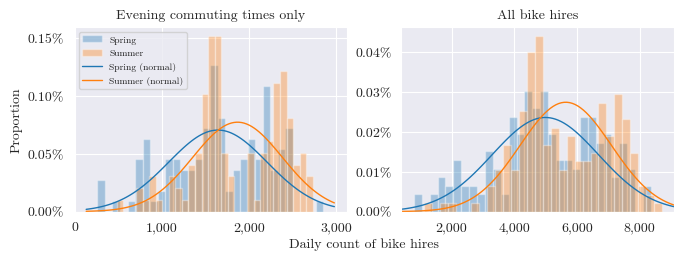

In [41]:
# Setup normal distributions
mu_spring_peak, std_spring_peak = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==2])
mu_summer_peak, std_summer_peak = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==3])

mu_spring_all, std_spring_all = norm.fit(day_data['cnt'][day_data.season==2])
mu_summer_all, std_summer_all = norm.fit(day_data['cnt'][day_data.season==3])

# Subplot setup
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(7.75,0.8*3))

# Peak evenings histogram
ax0.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==2], alpha=0.35, density=True, bins=30, label='Spring')
ax0.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==3], alpha=0.35, density=True, bins=30, label='Summer')

# All days histogram
ax1.hist(day_data['cnt'][day_data.season==2], alpha=0.35, density=True, bins=30)
ax1.hist(day_data['cnt'][day_data.season==3], alpha=0.35, density=True, bins=30)

# Normal dist - peak evenings
x_min_peak, x_max_peak = ax0.get_xlim()
x_peak = np.linspace(x_min_peak, x_max_peak, 100)

p_spring_peak = norm.pdf(x_peak, mu_spring_peak, std_spring_peak)
p_summer_peak = norm.pdf(x_peak, mu_summer_peak, std_summer_peak)

ax0.plot(x_peak, p_spring_peak, 'C0', linewidth=1, label='Spring (normal)')
ax0.plot(x_peak, p_summer_peak, 'C1', linewidth=1, label = 'Summer (normal)')

# Normal dist - all days
x_min_all, x_max_all = ax1.get_xlim()
x_all = np.linspace(x_min_all, x_max_all, 100)

p_spring_all = norm.pdf(x_all, mu_spring_all, std_spring_all)
p_summer_all = norm.pdf(x_all, mu_summer_all, std_summer_all)

ax1.plot(x_all, p_spring_all, 'C0', linewidth=1)
ax1.plot(x_all, p_summer_all, 'C1', linewidth=1)

# Plotting setup
plt.margins(x=0)
#plt.figlegend(loc = 1, fontsize = 'x-small')
ax0.legend(fontsize = 'x-small')
fig.supxlabel("Daily count of bike hires", y=-0.05, fontsize = 10)
ax0.set_ylabel('Proportion')
ax0.set_title("Evening commuting times only", fontsize=10)
ax1.set_title("All bike hires", fontsize=10)
ax0.yaxis.set_major_formatter(tick.PercentFormatter(xmax=1, decimals=2))
ax1.yaxis.set_major_formatter(tick.PercentFormatter(xmax=1, decimals=2))
ax0.xaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.savefig('plots/All combined histograms.png', bbox_inches="tight")

The histogram above shows that neither of the two distributions appear to follow a normal distribution, nor do they seem to follow similar distributions.

## Q-Q Plots

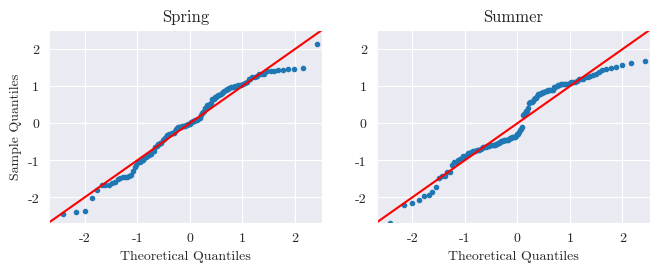

In [27]:
fig, (ax0, ax1)= plt.subplots(ncols=2, figsize=(7.75,2.5), sharex=True, sharey=True)
sm.qqplot(peak_evenings_daily['sum'][peak_evenings_daily.season==2], line='45', fit=True, ax = ax0, markersize=3)
ax0.set_title('Spring')
sm.qqplot(peak_evenings_daily['sum'][peak_evenings_daily.season==3], line='45', fit=True, ax = ax1, markersize=3)
ax1.set_title('Summer')
ax1.set_ylabel(None)
ax1.yaxis.set_tick_params(labelleft=True)
fig.savefig('plots/QQ plots.png', bbox_inches="tight")

## Other descriptive charts

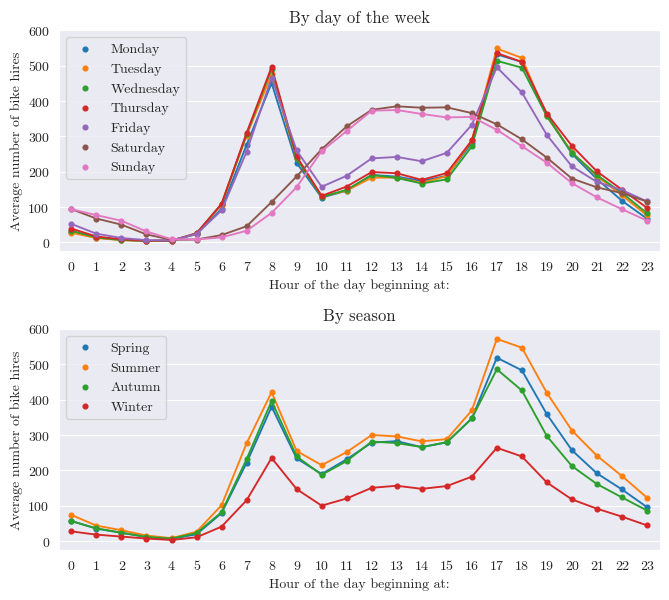

In [28]:
# Setting up plot
fig, (ax0, ax1)= plt.subplots(nrows=2, figsize=(7.75,6.75), sharex=True, sharey=True)

## PLOT BY WEEK DAY

# Fixing weekday mapping
week_day_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
hour_data['day'] = hour_data.weekday.map(week_day_map)

# Plotting by hour - by weekday
sns.pointplot(data=hour_data[['hr', 'cnt','day']][hour_data.holiday==0],
              x='hr',
              y='cnt',
              hue='day',
              hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
              errorbar=None,
              ax=ax0,
              scale = 0.5)

# Label and title settings for plot by weekday
ax0.set_title("By day of the week")
ax0.set_ylabel('Average number of bike hires')
ax0.set_xlabel("Hour of the day beginning at:")
ax0.xaxis.set_tick_params(labelbottom=True)
ax0.legend(loc = 'upper left')
ax0.grid(visible=True, axis = 'y')

## PLOT BY SEASON

# Mapping seasons
s_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
hour_data['season_name'] = hour_data.season.map(s_map)

# Plotting by hour - by season
sns.pointplot(data=hour_data[['hr', 'cnt','season_name']],
              x='hr',
              y='cnt',
              hue='season_name',
              hue_order=['Spring', 'Summer', 'Autumn', 'Winter'],
              errorbar=None,
              ax=ax1,
              scale = 0.5)

# Label and title settings for plot by season
ax1.set_title("By season")
ax1.set_ylabel("Average number of bike hires")
ax1.set_xlabel("Hour of the day beginning at:")
ax1.legend(loc = 'upper left')
ax1.grid(visible=True, axis = 'y')

# Save plot
plt.subplots_adjust(hspace=0.35)
fig.savefig('plots/Hourly distribution charts.png', bbox_inches="tight")

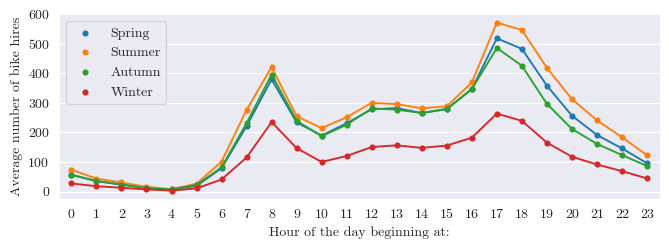

In [38]:
# BY SEASON CHART ONLY
fig, ax= plt.subplots(figsize=(7.75,0.8*3))

# Mapping seasons
s_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
hour_data['season_name'] = hour_data.season.map(s_map)

# Plotting by hour - by season
sns.pointplot(data=hour_data[['hr', 'cnt','season_name']],
              x='hr',
              y='cnt',
              hue='season_name',
              hue_order=['Spring', 'Summer', 'Autumn', 'Winter'],
              errorbar=None,
              ax=ax,
              scale = 0.5)

# Label and title settings for plot by season
ax.set_title(None)
ax.set_ylabel("Average number of bike hires")
ax.set_xlabel("Hour of the day beginning at:")
ax.legend(loc = 'upper left')
ax.grid(visible=True, axis = 'y')
#ax.set_xticks(ticks = [i for i in range(0,24,2)])
ax.set_yticks(ticks = [i for i in range(0,700,100)])

# Save plot
plt.subplots_adjust(hspace=0.35)
fig.savefig('plots/Hourly distribution charts - by season.png', bbox_inches="tight")

In [30]:
# Amount of replicate data
same_table_spring = peak_evenings_daily[peak_evenings_daily.season==2].duplicated(subset = ['sum']).value_counts()
same_table_summer = peak_evenings_daily[peak_evenings_daily.season==3].duplicated(subset = ['sum']).value_counts()
print("Proportion of data points in spring with replicate values:", same_table_spring[1]/(same_table_spring[1]+same_table_spring[0]))
print("Proportion of data points in summer with replicate values:", same_table_summer[1]/(same_table_summer[1]+same_table_summer[0]))

Proportion of data points in spring with replicate values: 0.0234375
Proportion of data points in summer with replicate values: 0.03816793893129771


## Statistical Tests
Chi Squared Test

In [31]:
import scipy.stats
spring =  day_data[day_data.season==2]['cnt'].values
summer =  day_data[day_data.season==3]['cnt'].values

def pearson_chisquare(observed_data, expected_data):

    # Create empty dataframe
    df_bins = pd.DataFrame()

    # Calculate number of bins
    num_bins = round(2 * (len(observed_data)**0.4))

    # Generate bins from expected group
    _, bins = pd.qcut(observed_data, q=num_bins, retbins=True)
    df_bins['bin'] = pd.cut(observed_data, bins=bins).value_counts().index

    # Apply bins to both groups
    df_bins['expected_data'] = pd.cut(expected_data, bins=bins).value_counts().values
    df_bins['observed_data'] = pd.cut(observed_data, bins=bins).value_counts().values

    # Compute expected frequency in the treatment group
    df_bins['observed_standardised'] = (df_bins['observed_data'] / np.sum(df_bins['observed_data'])) * np.sum(df_bins['expected_data'])

    # Critical value (5%)
    cv = scipy.stats.chi2.ppf(1-.05, df=num_bins-1)

    # Carrying out test
    stat, p_value = scipy.stats.chisquare(df_bins['expected_data'], df_bins['observed_standardised'], )
    print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}, critical value={cv: .4f}, bins={num_bins:.4f}")

In [32]:
pearson_chisquare(observed_data = spring, expected_data = summer)
pearson_chisquare(observed_data = summer, expected_data = spring)

Chi-squared Test: statistic=66.7579, p-value=0.0000, critical value= 24.9958, bins=16.0000
Chi-squared Test: statistic=100.8118, p-value=0.0000, critical value= 24.9958, bins=16.0000


In [33]:
# Init dataframe
df_bins = pd.DataFrame()
spring = day_data[day_data.season==2]['cnt'].values
summer = day_data[day_data.season==3]['cnt'].values

# Generate bins from control group
_, bins = pd.qcut(spring, q=16, retbins=True)
df_bins['bin'] = pd.cut(spring, bins=bins).value_counts().index

# Apply bins to both groups
df_bins['cnt_spring_observed'] = pd.cut(spring, bins=bins).value_counts().values
df_bins['cnt_summer_observed'] = pd.cut(summer, bins=bins).value_counts().values

# Compute expected frequency in the treatment group
df_bins['cnt_summer_expected'] = (df_bins['cnt_spring_observed'] / np.sum(df_bins['cnt_spring_observed'])) * np.sum(df_bins['cnt_summer_observed'])

df_bins

,bin,cnt_spring_observed,cnt_summer_observed,cnt_summer_expected
0,"(795.0, 2096.25]",11,3,11.180328
1,"(2096.25, 2838.625]",11,1,11.180328
2,"(2838.625, 3383.562]",12,2,12.196721
3,"(3383.562, 4003.0]",11,14,11.180328
4,"(4003.0, 4230.125]",12,5,12.196721
5,"(4230.125, 4480.0]",11,15,11.180328
6,"(4480.0, 4718.688]",12,21,12.196721
7,"(4718.688, 4941.5]",11,17,11.180328
8,"(4941.5, 5165.875]",11,7,11.180328
9,"(5165.875, 5657.375]",12,15,12.196721


In [34]:
from scipy.stats import chisquare

stat, p_value = chisquare(df_bins['cnt_summer_observed'], df_bins['cnt_summer_expected'])
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.10f}")

Chi-squared Test: statistic=66.7579, p-value=0.0000000168


Anderson-Darling Test for two samples

In [35]:
from scipy.stats import anderson_ksamp
statistic, crit, p = anderson_ksamp([spring,summer])

print(statistic, crit, p)

8.606740574320579 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001


C:\Users\roryc\AppData\Local\Temp\ipykernel_596\632093259.py:2: UserWarning: p-value floored: true value smaller than 0.001
  statistic, crit, p = anderson_ksamp([spring,summer])


In [36]:
statistic, crit, p = anderson_ksamp([summer,spring])
print(statistic, crit, p)

8.606740574320579 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001


C:\Users\roryc\AppData\Local\Temp\ipykernel_596\3113313703.py:1: UserWarning: p-value floored: true value smaller than 0.001
  statistic, crit, p = anderson_ksamp([summer,spring])
